# Multi-class Classification and Neural Networks

## 1. Multi-class Classification
In this exercise, we will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). 

### 1.1 Dataset
The dataset ex3data1.mat contains 5000 training examples of handwritten digits. Each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location (value between -1 and 1). The 20 by 20 grid of pixels are flattened into a 400 long vector. Each training example is a single row in data matrix X. This results in a 5000 by 400 matrix X where every row is a training example. 

$$ X=\left[\matrix{-(x^{(1)})^T-\\ -(x^{(2)})^T-\\ \vdots\\ -(x^{(m)})^T-}\right]_{5000\times400} $$

The other dtat in the training set is a 5000 long vector y that contains labels for the training set. Since the data was prepared for MATLAB, in which index starts from 1, digits 0-9 have been converted to 1-10. Here, we will convert it back to using 0-9 as labels. 

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [23]:
from scipy.io import loadmat

data = loadmat('ex3data1.mat')

X = data["X"]   # 5000x400 np array
y = data["y"]   # 5000x1 np array (2d)
y = y.flatten() # change to (5000,) 1d array and 
y[y==10] = 0    # convert to 0-9 scale from 1-10 scale

### 1.2 Visualizing the data

In [24]:
def displayData(X):
    """displays the 100 rows of digit image data stored in X in a nice grid. 
        It returns the figure handle fig, ax
    """
    
    # form the big 10 x 10 matrix containing all 100 images data
    # padding between 2 images
    pad = 1
    # initialize matrix with -1 (black)
    wholeimage = -np.ones((20*10+9, 20*10+9))
    # fill values
    for i in range(10):
        for j in range(10):
            wholeimage[j*21:j*21+20, i*21:i*21+20] = X[10*i+j, :].reshape((20, 20))
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(wholeimage.T, cmap=plt.cm.gray, vmin=-1, vmax=1)
    ax.axis('off')
    
    return fig, ax

(-0.5, 208.5, 208.5, -0.5)

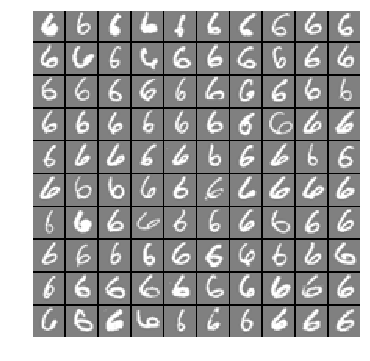

In [25]:
x = X[3200:3300, :]

fig, ax = displayData(x)
ax.axis('off')

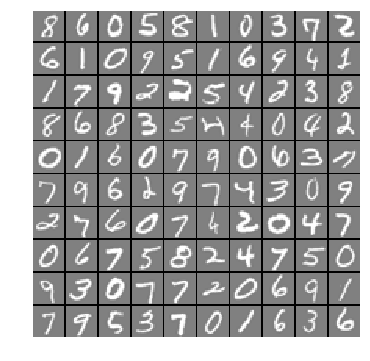

In [26]:
# randomly select 100 data points to display
rand_indices = np.random.randint(0, 5000, size=100)
sel = X[rand_indices, :]

# display images
fig, ax = displayData(sel)

### 1.3 Vectorizing Logistic Regression
Since it's already been vectorized in assignment 2, we will just copy the functions here, just renaming it to lrCostFunction(). This includes regularization. 

In [27]:
def sigmoid(z):
    """sigmoid(z) computes the sigmoid of z. z can be a number,
    vector, or matrix. 
    """
    
    g = 1 / (1 + np.exp(-z))
    
    return g

In [28]:
def lrCostFucntion(theta, X, y, lmd):
    """computes the cost of using
%   theta as the parameter for regularized logistic regression and the
%   gradient of the cost w.r.t. to the parameters.
    """
    
    m = len(y)
    
    # prepare for matrix calculations
    y = y[:, np.newaxis]
    theta = theta[:, np.newaxis]
    
    
#     print('theta: {}'.format(theta.shape))
#     print('X: {}'.format(X.shape))
#     print('y: {}'.format(y.shape))
    # cost
    J = (-y.T@np.log(sigmoid(X@theta)))/m - ((1-y.T)@np.log(1-sigmoid(X@theta)))/m + (theta[1:].T@theta[1:])*lmd/(2*m)
    # J = J[0, 0]
    
    # gradient
    grad = np.zeros(theta.shape)

    # added newaxis in order to get 2d array instead of 1d array
    grad[0] = X.T[0, np.newaxis, :]@(sigmoid(X@theta)-y)/m
    
    grad[1:] = X.T[1:, :]@(sigmoid(X@theta)-y)/m + lmd*theta[1:]/m
    
    return J, grad.flatten()

In [29]:
# Test lrCostFunction
theta_t = np.array([-2, -1, 1, 2])
X_t = np.concatenate((np.ones((5, 1)), np.arange(1, 16).reshape((5, 3), order='F')/10), axis=1)
y_t = np.array([1, 0, 1, 0, 1])
lambda_t = 3
J, grad = lrCostFucntion(theta_t, X_t, y_t, lambda_t)

In [30]:
print('Cost: {:.6f}'.format(J[0, 0]))
print('Expected: 2.534819')
print('Gradients: \n{}'.format(grad))
print('Expected: \n0.146561\n -0.548558\n 0.724722\n 1.398003\n')

Cost: 2.534819
Expected: 2.534819
Gradients: 
[ 0.14656137 -0.54855841  0.72472227  1.39800296]
Expected: 
0.146561
 -0.548558
 0.724722
 1.398003



### 1.4 One-vs-all Classification
Here, we implement one-vs-all classification by training multiple regularized logistic regression classifier, one for each of the K classes in our dataset. K=10 in this case. 

In [31]:
from scipy.optimize import minimize

In [32]:
def oneVsAll(X, y, num_class, lmd):
    """trains num_labels logistic regression classifiers and returns each of these classifiers
%   in a matrix all_theta, where the i-th row of all_theta corresponds 
%   to the classifier for label i
    """
    
    # m is number of training samples, n is number of features + 1
    m, n = X.shape
    
    # store theta results
    all_theta = np.zeros((num_class, n))
    #print(all_theta.shape)
    
    # initial conidition, 1d array
    theta0 = np.zeros(n)
    print(theta0.shape)
    
    # train one theta at a time
    for i in range(num_class):
        
        # y should be either 0 or 1, representing true or false
        ylabel = (y==i).astype(int)
        
        # run optimization
        result = minimize(lrCostFucntion, theta0, args=(X, ylabel, lmd), method='TNC', jac=True, options={'disp': True, 'maxiter':1000})
        # print(result)
        all_theta[i, :] = result.x
        
    return all_theta

In [33]:
# prepare parameters
lmd = 0.1
m = len(y)
X_wb = np.concatenate((np.ones((m, 1)), X), axis=1)
num_class = 10    # 10 classes, digits 0 to 9

print(X_wb.shape)
print(y.shape)

# Run training
all_theta = oneVsAll(X_wb, y, num_class, lmd)
print(all_theta[4000:4020])

(5000, 401)
(5000,)
(401,)
[]


#### One-vs-all Prediction

In [34]:
def predictOneVsAll(all_theta, X):
    """will return a vector of predictions
%  for each example in the matrix X. Note that X contains the examples in
%  rows. all_theta is a matrix where the i-th row is a trained logistic
%  regression theta vector for the i-th class. You should return column vector 
%  of values from 1..K (e.g., p = [1; 3; 1; 2] predicts classes 1, 3, 1, 2
%  for 4 examples)
    """
    
    # apply np.argmax to the output matrix to find the predicted label 
    # for that training sample
    out = (all_theta @ X.T).T
    #print(out[4000:4020, :])
    return np.argmax(out, axis=1)

In [35]:
# prediction accuracy
pred = predictOneVsAll(all_theta, X_wb)
print(pred.shape)

accuracy = np.sum((pred==y).astype(int))/m*100
print('Training accuracy is {:.2f}%'.format(accuracy))

(5000,)
Training accuracy is 96.46%


## 2. Neural Networks
In the previous part of this exercise, you implemented multi-class logistic re-
gression to recognize handwritten digits. However, logistic regression cannot
form more complex hypotheses as it is only a linear classifier.3
In this part of the exercise, you will implement a neural network to rec-
ognize handwritten digits using the same training set as before. The neural
network will be able to represent complex models that form non-linear hy-
potheses.

For this week, you will be using parameters from a neural network
that we have already trained. Your goal is to implement the feedforward
propagation algorithm to use our weights for prediction.

Our neural network is shown in Figure 2. It has 3 layers: an input layer, a
hidden layer and an output layer. Recall that our inputs are pixel values of
digit images. Since the images are of size 20x20, this gives us 400 input layer
units (excluding the extra bias unit which always outputs +1). As before,
the training data will be loaded into the variables X and y.

A set of pre-trained network parameters ($\Theta_{(1)},\Theta_{(2)}$) are provided and stored in ex3weights.mat. The neural network used contains 25 units in the 2nd layer and 10 output units (corresponding to 10 digit classes).

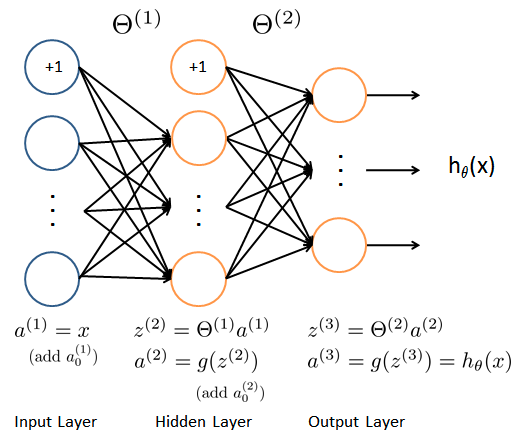

In [36]:
#from scipy.io import loadmat

data = loadmat('ex3weights.mat')

Theta1 = data["Theta1"]   # 25x401 np array
Theta2 = data["Theta2"]   # 10x26 np array (2d)
print(Theta1.shape, Theta2.shape)

(25, 401) (10, 26)


### Vectorizing the forward propagation
Matrix dimensions:

$X_wb$: 5000 x 401

$\Theta^{(1)}$: 25 x 401

$\Theta^{(2)}$: 10 x 26

$a^{(2)}$: 5000 x 25 or 5000 x 26 after adding intercept terms

$a^{(3)}$: 5000 x 10

$$a^{(2)} = g(X_{wb}\Theta^{(1)^T})$$

$$a^{(3)} = g(a^{(2)}_{wb}\Theta^{(2)^T})$$

In [37]:
def predict(X, Theta1, Theta2):
    """ predicts output given network parameters Theta1 and Theta2 in Theta. 
        The prediction from the neural network will be the label that has the largest output.
    """
    
    a2 = sigmoid(X @ Theta1.T)
    
    # add intercept terms to a2
    m, n = a2.shape
    a2_wb = np.concatenate((np.ones((m, 1)), a2), axis=1)
    
    a3 = sigmoid(a2_wb @ Theta2.T)
#     print(a3[:10, :])
    
    # apply np.argmax to the output matrix to find the predicted label 
    # for that training sample
    # correct for indexing difference between MATLAB and Python
    p = np.argmax(a3, axis=1) + 1
    p[p==10] = 0

    return p # this is a 1d array

In [38]:
# prediction accuracy
pred = predict(X_wb, Theta1, Theta2)
print(pred.shape)


accuracy = np.sum((pred==y).astype(int))/m*100
print('Training accuracy is {:.2f}%'.format(accuracy))

(5000,)
Training accuracy is 97.52%


Predicted 2 for this image: 


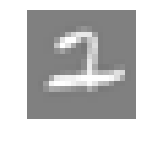

Predicted 5 for this image: 


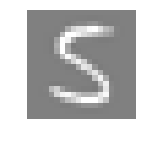

Predicted 4 for this image: 


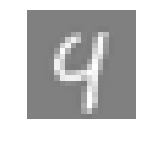

Predicted 0 for this image: 


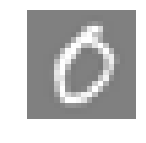

Predicted 2 for this image: 


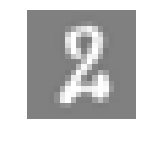

Predicted 9 for this image: 


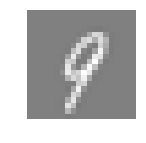

Predicted 3 for this image: 


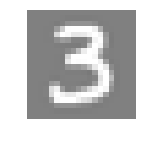

Predicted 9 for this image: 


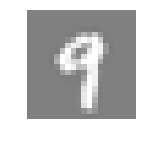

Predicted 6 for this image: 


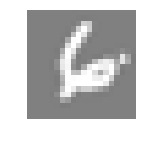

Predicted 2 for this image: 


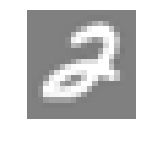

In [39]:

# randomly show 10 images and corresponding results
# randomly select 10 data points to display
rand_indices = np.random.randint(0, 5000, size=10)
sel = X[rand_indices, :]

for i in range(10):
    
    # Display predicted digit
    print("Predicted {} for this image: ".format(pred[rand_indices[i]]))
    
    # display image
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.imshow(sel[i, :].reshape(20, 20).T, cmap=plt.cm.gray, vmin=-1, vmax=1)
    ax.axis('off')
    plt.show()